In [1]:
from Game.BlackJack import BlackJack
from Agent.random.randomagent import RandomAgent
from Agent.nn.nnagent import nnAgent
from Agent.qlearning.qLearningAgent import qLearningAgent
from Agent.expectimax.expectimaxAgent import ExpectimaxAgent
from Agent.base.baseAgent import BaseAgent

import numpy as np
from tqdm import trange

In [2]:
game = BlackJack("novel")
agent1 = qLearningAgent()
agent2 = BaseAgent()

100%|██████████| 100000/100000 [00:01<00:00, 56999.23it/s]

win rates: 0.52302 lose rates: 0.39892 draw rates: 0.07806
0.5673037290929995


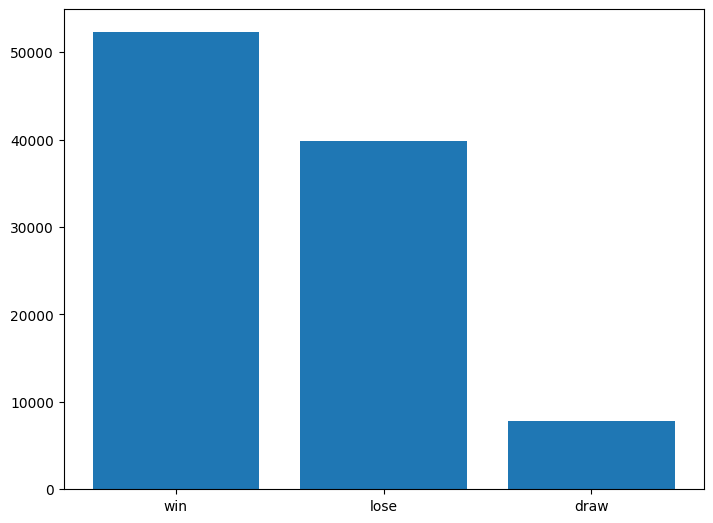

In [14]:
results = {"win": 0, "lose": 0, "draw": 0}
rounds = 100000

for i in trange(rounds):
    game.start()
    # print("Dealer shows:", game.format_cards(game.dealer_hand[:1]))
    while game.status == "continue":
        action = agent1.choose_action(game)
        game.play(action, "basic")
        if action == "stay":
            break
    # print(f"dealer's hand: {game.format_cards(game.dealer_hand)} {game.get_dealervalue()}  player's hand: {game.format_cards(game.player_hand)} {game.get_playervalue()}")
    
    results[game.game_result()] += 1
    
    # if len(game.deck) < 20:
    #     game.reset()
    game.reset()
        
print(f"win rates: {results['win']/rounds} lose rates: {results['lose']/rounds} draw rates: {results['draw']/rounds}")
print(results["win"]/(results["win"]+results["lose"]))
# Draw a bar graph
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(results.keys(), results.values())
plt.show()
